A starting note book for the study on small islands. 

The idea behind this session is to start having an initial look in how climate variables are being represented over small islands. The motivation comes from comparing against the current state of the art, e.g. CORDEX, where some islands are either not included in the regional domains or, as in the Africa domain, are represented at between 25 - 50 km. Here we have included the co-ordinates for the Canary Islands and Mascarene Islands as starting points (both on the boundary of the CORDEX Africa domain), but you can look at any islands you wish. 

Some ideas for this session include: 

- if you're familar with CORDEX start looking at how some of these islands are represented in CORDEX Africa 
- see how well orography is represented on a range of islands, e.g. we know Tenerife is a volcanic island with a lot more precipitation in the North than South, can we capture this in the model? 
- how well is wind speed captured, can we improve on this paper: https://www.mdpi.com/2071-1050/13/8/4104
- identify an extreme event that occured in one of these islands between 2017 - 2023 and use the storyline simulations to examine this event 
- tropical cyclones in AQUA 
- run your application over an island subdomain 
- general discussion about added value over island nations :) 

This paper https://www.nature.com/articles/s41558-024-02028-9 identifies some areas of study required for small islands 



In [1]:
import numpy as np 
import os 
import xarray as xr
#import regionmask 
#import geopandas as gp
#import cmocean 
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from matplotlib.colors import BoundaryNorm

import matplotlib.tri as tri

#import easygems.healpix as egh
import healpy as hp

#import easygems.healpix as egh
import cartopy.feature as cf
import healpy as hp

# importing AQUA 
import aqua
from aqua import Reader

# importing GSV 
from gsv import GSVRetriever
from gsv.requests.parser import parse_request
from gsv.requests.utils import convert_to_step_format


In [2]:
def ticks_round(ticks: list, round_to: int = None):
    """
    Round a tick to the nearest round_to value.

    Args:
        tick (list):          Tick value.
        round_to (int, opt):  Round to value.

    Returns:
        tick (list):  Rounded tick value.
    """
    if round_to is None:
        # define round_to
        tick_span = ticks[1] - ticks[0]
        if tick_span <= 1:
            round_to = 2
        elif tick_span > 1 and tick_span <= 10:
            round_to = 1
        else:
            round_to = 0

    return np.round(ticks, round_to)

def plot_islands(to_plot, grid_type, max_value, latitude, longitude, var, title):

    projection = ccrs.PlateCarree()

    fsize = 14
    #Add tick marks with values for latitude and longitude axes
    nxticks = 5
    nyticks = 7
    
    #cmap = #cmocean.cm.thermal
    cmap = 'Blues'

    #cmap = ListedColormap(cmap)

    fig, ax = plt.subplots(1, 1, constrained_layout=False, figsize=(10, 10), 
                            subplot_kw={'projection': projection}) 


    if grid_type == "lat_lon":
        lons, lats = np.meshgrid(to_plot.lon.values, to_plot.lat.values)
        
        pcm = ax.pcolormesh(lons, lats, to_plot, transform= projection, 
            cmap=cmap, vmax = max_value, vmin = 0) 
        
        # ax.plot(to_plot.lon[loni], to_plot.lat[lati], marker='x', color='red', markersize=6, transform=projection)
        # ax.plot(to_plot.lon[loni2], to_plot.lat[lati2], marker='x', color='red', markersize=6, transform=projection)
    
    # elif grid_type == "healpix":
        
    #     ax.set_global()
    #     ax.set_extent([longitude[0], longitude[1], latitude[0], latitude[1]], crs=projection)
    #     pcm = egh.healpix_show(to_plot, ax=ax, vmax = max_value, cmap = cmap)

    elif grid_type == "native":
        triang = tri.Triangulation(to_plot.lon, to_plot.lat)
        pcm = plt.tricontourf(triang, to_plot.data, alpha=1,
            cmap=cmap, transform= projection) 

    ax.coastlines(resolution='10m', color='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        
    plt.title(f'{title}')

    # Latitude labels
    if grid_type == "healpix":
        lat_min = latitude[0]
        lat_max = latitude[1]
    else:
        lat_min = to_plot['lat'].values.min()
        lat_max = to_plot['lat'].values.max()
    step = (lat_max - lat_min) / (nyticks - 1)
    yticks = np.arange(lat_min, lat_max, step)
    yticks = ticks_round(ticks=yticks, round_to=None)
    ax.set_yticks(yticks, crs=projection)
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Latitude labels
    if grid_type == "healpix":
        lon_min = longitude[0]
        lon_max = longitude[1]
    else:
        lon_min = to_plot['lon'].values.min()
        lon_max = to_plot['lon'].values.max()
    step = (lon_max - lon_min) / (nxticks - 1)
    xticks = np.arange(lon_min, lon_max + 1, step)
    xticks = ticks_round(ticks=xticks, round_to=None)
    ax.set_xticks(xticks, crs=projection)
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    ax.tick_params(axis='y', labelsize=fsize) 
    ax.tick_params(axis='x', labelsize=fsize) 

    cbar_ax = fig.add_axes([0.36, 0.3, 0.28, 0.01]) 
    cbar = fig.colorbar(pcm, cax = cbar_ax, orientation='horizontal', shrink=0.4)
    
    cbar.set_ticks([0, max_value/3, 2*max_value/3, max_value])

    cbar.update_ticks()  # Updates the colorbar with the new ticks

    cbar.ax.tick_params(labelsize=fsize)
    cbar.set_label(f"{var}", fontsize = fsize)

    plt.show()

In [3]:
var = 'mtpr'

#coordinates of Canary islands whole domain 
canary_latitude = [27.2, 29.5]
canary_longitude = [-19, -12.5]

mascarene_latitude = [-19.6, -21.5]
mascarene_longitude = [54.7, 64.4]


In [4]:

reader = Reader(model="IFS-NEMO", exp="ssp370", source="hourly-hpz10-atm2d", streaming=True, 
        regrid = 'r010', aggregation = '3D', chunks = {'time' : 'D'}, startdate = '20200105') #regrid method

data = reader.retrieve()

data = data[var]

data = reader.regrid(data)

data['lon_adjusted'] = xr.where(data.lon > 180, data.lon - 360, data.lon)
data['lon'] = data['lon_adjusted']
data = data.reset_coords(names='lon_adjusted', drop=True)

indexer = ((data.lat>=canary_latitude[0]) & (data.lat<=canary_latitude[1]) & (data.lon>=canary_longitude[0]) & (data.lon<=canary_longitude[1])).compute()
data_can = data.where(indexer, drop=True)



In [ ]:
data_can

<xarray.DataArray 'mtpr' (time: 72, lat: 23, lon: 66)> Size: 874kB
dask.array<where, shape=(72, 23, 66), dtype=float64, chunksize=(24, 23, 66), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 576B 2020-01-05 ... 2020-01-07T23:00:00
  * lat      (lat) float64 184B 27.25 27.35 27.45 27.55 ... 29.25 29.35 29.45
  * lon      (lon) float64 528B -19.0 -18.9 -18.8 -18.7 ... -12.7 -12.6 -12.5
Attributes: (12/27)
    long_name:                       Mean total precipitation rate
    units:                           kg m**-2 s**-1
    standard_name:                   unknown
    GRIB_paramId:                    228
    GRIB_shortName:                  tp
    GRIB_units:                      m
    ...                              ...
    shortName:                       mtpr
    time_conversion_flag:            1
    factor:                          0.2777777777777778
    src_units:                       m
    units_fixed:                     1
    regridded:                       1

In [8]:
cbar_max = np.round(np.max(data_can.sum(axis = 0).values), 4) 

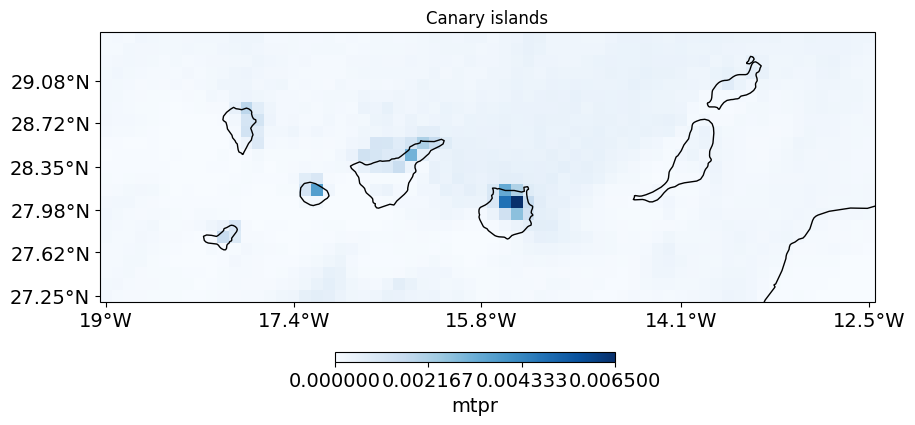

In [10]:
plot_islands(data_can.sum(axis = 0), "lat_lon", cbar_max, canary_latitude, canary_longitude, var, "Canary islands")